# Unit 5 - Financial Planning


In [ ]:
#Assignment: APIs Homework
#Due date: May 22nd, 2021
#Name: Thomas J. Scott

In [114]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import datetime
import time

%matplotlib inline

#importing this just in case
import matplotlib.pyplot as plt

In [162]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [52]:
# Fetch current BTC price
get_btc_price = requests.get(btc_url)

#read data as JSON
btc_price_json = get_btc_price.json()

#pull the price data from the JSON output
btc_price = btc_price_json['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
get_eth_price = requests.get(eth_url)

#read data as JSON
eth_price_json = get_eth_price.json()

#pull the price data from the JSON output
eth_price = eth_price_json['data']['1027']['quotes']['USD']['price']

# Compute current value of your crpto holdings (the formula is: the amount of crypto you have timees its current price)
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print your current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")
print("\nTake that IRS!")

The current value of your 1.2 BTC is $45210.00
The current value of your 5.3 ETH is $13007.26

Take that IRS!


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [53]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [163]:
# Set Alpaca API key and secret eky
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [171]:
# Format current date as ISO format
#use datetime and time libraries to return today's date
todays_date = datetime.date.fromtimestamp(time.time());

#return today's date in ISO format
todays_date_ISOFormat = todays_date.isoformat();

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start = todays_date_ISOFormat,
    end = todays_date_ISOFormat,
    limit=1,
).df

# Display sample data
df_ticker.head()

# Preview DataFrame
df_ticker

AGG                                     SPY  \
                             open   high     low   close   volume    open   
time                                                                        
2021-05-21 00:00:00-04:00  114.36  114.4  114.23  114.32  3350907  416.87   

                                                            
                            high     low   close    volume  
time                                                        
2021-05-21 00:00:00-04:00  418.2  414.45  414.95  66393170

In [83]:
# Pick AGG and SPY close prices by pulling the data from the ticker dataframe and converting it to a float
spy_close_price = float(df_ticker[tickers[1]]['close'])

agg_close_price = float(df_ticker[tickers[0]]['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.32
Current SPY closing price: $414.95


In [84]:
# Compute the current value of shares (formuala is: close price * number of shares held)
my_spy_value = spy_close_price * my_spy

my_agg_value = agg_close_price * my_agg

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20747.50
The current value of your 200 AGG shares is $22864.00


### Savings Health Analysis

In [158]:
# Set monthly household income
monthly_income = 12000

#generate totals for the asset classes in your model portfolio
crypto_value = my_btc_value + my_eth_value
shares_value = my_spy_value + my_agg_value

savings_indexes = ['crypto', 'shares']

# Create savings DataFrame
df_savings = pd.DataFrame({'Price': [crypto_value, shares_value]}, 
                          index = savings_indexes)

# Display savings DataFrame
display(df_savings)

,Price
crypto,58217.26
shares,43611.50


<AxesSubplot:ylabel='Price'>

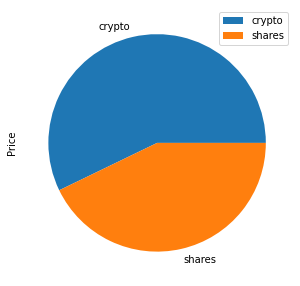

In [146]:
# Plot savings pie chart
df_savings.plot.pie(y='Price', figsize=(5, 5))

In [165]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings by adding contents of the price column in the dataframe
savings_total = df_savings['Price'].sum()

# Validate saving health
if savings_total >= emergency_fund:
    print(f"Congratulations Credit Union Member! Your total savings of ${savings_total} exceeds our recommended minimum of ${emergency_fund}!\n")

else:
    print("WARNING: please start saving more money ASAP!\n")

Congratulations Credit Union Member! Your total savings of $101828.76 exceeds our recommended minimum of $36000!



## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [169]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen

# I changed the window to reflect the last 5 years ending in this past Thursday. 
# The 2016 start date was a Saturday when the market was closed so I went back a day
start_date = pd.Timestamp('2016-05-20', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-20', tz='America/New_York').isoformat()

# Display the 5 year window with the the start and end dates in ISO format
print("Your 5 year sample window is as follows:")
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Your 5 year sample window is as follows
Start date: 2016-05-20T00:00:00-04:00
End date: 2021-05-20T00:00:00-04:00


In [183]:
# Get 5 years' worth of historical data for SPY and AGG

df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000
).df

#drop null values from the dataframe
df_stock_data_drop_nulls = df_stock_data.dropna()

# Display sample data
df_stock_data_drop_nulls.head()

AGG                                        SPY  \
                             open    high       low   close   volume    open   
time                                                                           
2017-06-01 00:00:00-04:00  109.36  109.50  109.3409  109.47  2241270  241.96   
2017-06-02 00:00:00-04:00  109.74  109.89  109.7047  109.84  1322101  243.41   
2017-06-05 00:00:00-04:00  109.66  109.74  109.6000  109.66  2074161  243.98   
2017-06-06 00:00:00-04:00  109.87  109.95  109.8100  109.87  1434088  243.31   
2017-06-07 00:00:00-04:00  109.81  109.87  109.7000  109.73  1570692  243.60   

                                                              
                             high     low    close    volume  
time                                                          
2017-06-01 00:00:00-04:00  243.34  241.64  243.320  50837868  
2017-06-02 00:00:00-04:00  244.35  243.08  244.130  50298878  
2017-06-05 00:00:00-04:00  244.30  243.76  243.965  27596403  
2017-06-06 00:00:00-04:00  243.98  243.12  243.250  36562468  
2017-06-07 00:00:00-04:00  243.92  242.83  243.650  38602639

In [200]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Per the instructions we are weighting the portfolio 60% stocks and 40% bonds and naming the variable accordingly
# I am giving the variable a dynamic name just in case the evaluator wants to adjust the weights

# Create variables setting the number of trading days equal to the number of days the market is open
# as well as the number of years in we are forecasting

trading_days_in_year = 252
forecast_years = 30

MC_weighted = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.6,.4],
    
# I am also setting 'num_simulation' equal to 500 per the instructions since we are told to only run 500 simulations
    num_simulation = 500,
    
    num_trading_days = trading_days_in_year * forecast_years
)

In [201]:
# Printing the simulation input data
MC_weighted.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
time                                                                   
2017-06-01 00:00:00-04:00  109.36  109.50  109.3409  109.47  2241270   
2017-06-02 00:00:00-04:00  109.74  109.89  109.7047  109.84  1322101   
2017-06-05 00:00:00-04:00  109.66  109.74  109.6000  109.66  2074161   
2017-06-06 00:00:00-04:00  109.87  109.95  109.8100  109.87  1434088   
2017-06-07 00:00:00-04:00  109.81  109.87  109.7000  109.73  1570692   

                                           SPY                           \
                          daily_return    open    high     low    close   
time                                                                      
2017-06-01 00:00:00-04:00          NaN  241.96  243.34  241.64  243.320   
2017-06-02 00:00:00-04:00     0.003380  243.41  244.35  243.08  244.130   
2017-06-05 00:00:00-04:00    -0.001639  243.98  244.30  243.76  243.965   
2017-06-06 00:00:00-04:00     0.001915  243.31  243.98  243.12  243.250   
2017-06-07 00:00:00-04:00    -0.001274  243.60  243.92  242.83  243.650   

                                                  
                             volume daily_return  
time                                              
2017-06-01 00:00:00-04:00  50837868          NaN  
2017-06-02 00:00:00-04:00  50298878     0.003329  
2017-06-05 00:00:00-04:00  27596403    -0.000676  
2017-06-06 00:00:00-04:00  36562468    -0.002931  
2017-06-07 00:00:00-04:00  38602639     0.001644

In [202]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_cum_return = MC_weighted.calc_cumulative_return()
MC_cum_return

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008662,0.993758,1.006634,0.994236,1.014288,0.996154,0.999893,0.994125,1.001581,1.007610,...,0.990567,0.999943,0.997530,0.998932,1.000636,1.009236,0.999599,1.000501,0.997392,1.008657
2,1.006334,0.997723,1.007413,1.003360,1.010027,0.993683,0.996829,0.996888,0.998773,1.006330,...,0.999618,0.995083,1.001123,1.002203,1.007754,1.000878,0.997978,1.000749,1.001568,1.005109
3,1.011641,0.993722,1.003022,1.009931,1.004650,0.996003,0.990724,1.004718,0.990411,1.001755,...,1.004678,0.989777,0.997570,1.002054,1.002851,1.007712,0.991555,1.008376,0.992640,1.010609
4,1.013842,0.989631,1.013901,1.010537,1.003648,0.989892,0.987607,1.002720,0.986970,1.005187,...,0.996497,0.988074,0.993036,0.997594,1.002701,1.019035,0.981925,0.999993,0.994018,1.014044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.261080,3.165608,4.589062,17.694476,2.478249,5.990308,9.116062,6.183402,4.437770,5.592602,...,4.882319,7.532978,11.796890,8.045567,8.403788,7.654366,5.964942,7.686421,8.880954,3.739069
7557,8.302131,3.182290,4.589750,17.464571,2.476795,5.955482,9.122767,6.195587,4.427556,5.573667,...,4.909607,7.565979,11.848627,8.072596,8.355547,7.721660,6.011548,7.743247,8.851108,3.747541
7558,8.395263,3.182861,4.637184,17.518524,2.500791,5.995873,9.069037,6.173591,4.414488,5.522492,...,4.898918,7.566992,11.706787,8.032691,8.287059,7.721619,6.009590,7.740177,8.862091,3.725745
7559,8.419343,3.189676,4.651448,17.508248,2.508756,5.956807,9.053470,6.063459,4.423902,5.524686,...,4.887114,7.557587,11.644079,8.026840,8.328558,7.692076,5.973715,7.738460,8.894400,3.739117


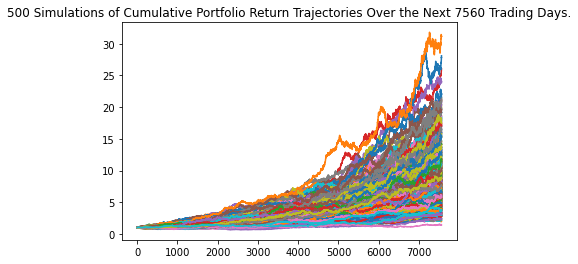

In [213]:
# Plot simulation outcomes
MC_plot = MC_weighted.plot_simulation()

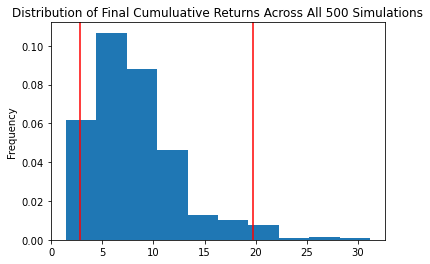

In [206]:
# Plot probability distribution and confidence intervals
MC_dist_plot = MC_weighted.plot_distribution()

### Retirement Analysis

In [207]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_tbl = MC_weighted.summarize_cumulative_return()

# Print summary statistics
print(MC_tbl)

count           500.000000
mean              8.169481
std               4.354146
min               1.417794
25%               5.074626
50%               7.364969
75%              10.126098
max              31.213172
95% CI Lower      2.840894
95% CI Upper     19.782674
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [208]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_tbl[8]*initial_investment,2)

ci_upper = round(MC_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $56817.87 and $395653.48


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [209]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000

ci_lower = round(MC_tbl[8]*initial_investment,2)

ci_upper = round(MC_tbl[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $85226.81 and $593480.22


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [210]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
forecast_years = 5

MC_5_years = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.6,.4],
    num_simulation = 500,
    
    num_trading_days = trading_days_in_year * forecast_years
)

In [211]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_return = MC_5_years.calc_cumulative_return()
MC_5_year_return

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001795,0.994491,0.998701,1.006362,1.003070,1.003686,0.988586,1.000545,1.007604,1.008302,...,0.997419,1.000763,0.996510,1.004166,0.995878,1.002569,1.002287,0.995525,0.996839,1.002373
2,1.003806,0.983687,0.999883,0.998383,0.999457,1.008058,0.994777,1.002945,1.006322,1.013639,...,0.995892,1.003355,1.006206,0.998869,0.997098,1.006889,1.000684,0.997012,0.995376,1.002621
3,1.004985,0.997406,1.002688,1.006232,0.992983,1.006869,1.000221,1.006924,1.004162,1.005868,...,0.997148,1.002318,1.005046,0.995199,0.993337,1.007101,0.998786,0.994372,0.995039,1.005658
4,1.005520,1.002511,0.997903,1.010879,0.997037,1.008002,0.994493,1.000433,1.000117,1.007078,...,1.002679,1.003433,0.998080,0.995537,0.990781,1.019634,0.994369,0.979249,0.996650,1.011442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.347752,1.172248,1.747595,1.236865,1.730508,1.469155,1.417223,1.332185,1.054339,1.534374,...,1.368245,1.165767,1.876528,1.236147,1.454202,1.368807,1.115777,1.288726,0.898933,1.356870
1257,1.346720,1.166886,1.758773,1.240177,1.736305,1.460067,1.412002,1.326126,1.057108,1.554931,...,1.357164,1.161826,1.863944,1.239563,1.463095,1.355837,1.115843,1.298436,0.899421,1.349977
1258,1.342930,1.170597,1.765841,1.228593,1.734779,1.457548,1.406298,1.326423,1.053735,1.556512,...,1.361717,1.160532,1.858365,1.233216,1.467302,1.340312,1.126143,1.289578,0.902159,1.356646
1259,1.348256,1.172150,1.769907,1.230587,1.743119,1.450974,1.393609,1.314540,1.055220,1.559794,...,1.362262,1.164167,1.859438,1.240490,1.466610,1.349126,1.121575,1.293848,0.900305,1.342066


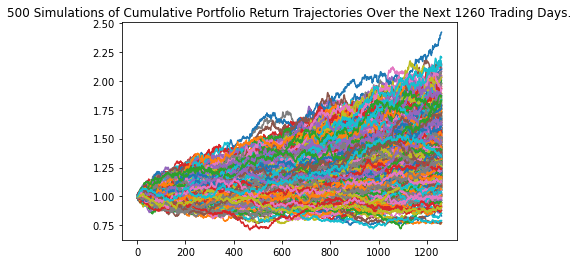

In [214]:
# Plot simulation outcomes
MC_5_year_plot = MC_5_years.plot_simulation() 

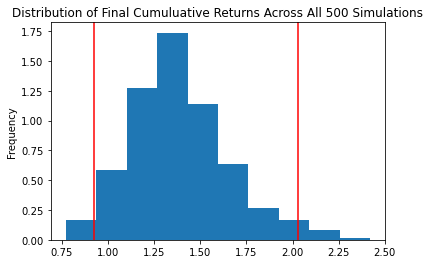

In [215]:
# Plot probability distribution and confidence intervals
MC_5_year_dist = MC_5_years.plot_distribution()

In [216]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_5_year_tbl = MC_5_years.summarize_cumulative_return()

# Print summary statistics
print(MC_5_year_tbl)

count           500.000000
mean              1.391644
std               0.266540
min               0.772750
25%               1.206953
50%               1.370842
75%               1.551790
max               2.420146
95% CI Lower      0.923761
95% CI Upper      2.028739
Name: 1260, dtype: float64


In [218]:
# Set initial investment
# Double check that current initial investment is equal to $60,000
initial_investment_five = initial_investment * 2

print(f"Initial investment: ${initial_investment_five}")

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(MC_tbl[8]*initial_investment_five,2)

ci_upper_five = round(MC_tbl[9]*initial_investment_five,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${int(initial_investment_five)} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

Initial investment: $60000.0
There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $170453.61 and $1186960.44


### Ten Years Retirement Option

In [219]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
forecast_years = 10

MC_10_years = MCSimulation(
    portfolio_data = df_stock_data_drop_nulls,
    weights = [.6,.4],
    num_simulation = 500,
    
    num_trading_days = trading_days_in_year * forecast_years
)

In [220]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10_year_return = MC_10_years.calc_cumulative_return()
MC_10_year_return

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004624,0.991182,0.992542,0.994049,1.001009,0.989428,1.009840,0.999154,1.006165,1.004349,...,1.000433,0.997055,1.001787,1.001092,1.014189,1.005735,1.005709,1.004830,0.999352,1.002942
2,1.006470,0.993772,0.988219,0.995588,0.999287,0.992996,1.006739,0.999355,1.012674,1.013338,...,0.996635,0.999452,1.001874,1.001097,1.013243,1.008638,0.998187,1.007230,1.001356,1.002431
3,1.006169,0.995428,0.987655,0.994379,1.000550,0.983729,1.013334,0.995709,1.007493,1.016538,...,1.005316,0.996094,1.001275,1.011379,1.011674,1.000513,0.998250,0.999685,1.001588,0.997730
4,1.002634,1.001097,0.994960,1.000190,1.010923,0.986475,1.006579,1.003480,1.017935,1.020190,...,1.001968,1.006305,1.004351,1.015615,1.009860,0.995883,0.998837,1.008193,1.009166,0.994253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.841299,1.907251,1.366084,1.130393,2.268521,2.738148,1.974868,1.829200,2.208641,2.631572,...,1.552710,1.640377,1.819301,2.134798,1.820385,1.705454,1.263694,1.819947,1.609452,1.846700
2517,2.823960,1.898834,1.353147,1.117055,2.257202,2.725218,1.982397,1.837374,2.197718,2.633214,...,1.560587,1.625123,1.837124,2.127756,1.828920,1.720631,1.268080,1.815806,1.615497,1.839504
2518,2.815894,1.891024,1.355751,1.114606,2.249617,2.713362,1.980772,1.814639,2.197563,2.617198,...,1.562337,1.634653,1.841601,2.122316,1.827191,1.708466,1.271654,1.820745,1.624881,1.816426
2519,2.818186,1.885230,1.350433,1.117268,2.238684,2.711389,1.972656,1.796096,2.192506,2.631814,...,1.554404,1.630259,1.862118,2.093452,1.825228,1.711112,1.264723,1.821348,1.623258,1.818893


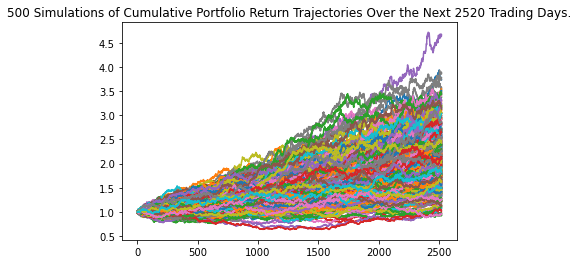

In [221]:
# Plot simulation outcomes
MC_10_year_plot = MC_10_years.plot_simulation()

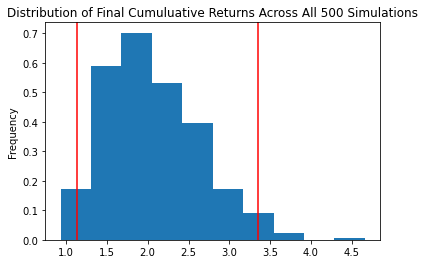

In [223]:
# Plot probability distribution and confidence intervals
MC_10_year_dist = MC_10_years.plot_distribution()

In [224]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_10_year_tbl = MC_10_years.summarize_cumulative_return()

# Print summary statistics
print(MC_10_year_tbl)

count           500.000000
mean              2.058114
std               0.572823
min               0.931380
25%               1.627903
50%               2.003256
75%               2.430812
max               4.660040
95% CI Lower      1.131898
95% CI Upper      3.345402
Name: 2520, dtype: float64


In [225]:
# Set initial investment & double check value
initial_investment_ten = initial_investment_five

print(f"Initial investment: ${initial_investment_ten}")

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(MC_tbl[8]*initial_investment_ten,2)

ci_upper_ten = round(MC_tbl[9]*initial_investment_ten,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_ten} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

Initial investment: $60000.0
There is a 95% chance that an initial investment of $60000.0 in the portfolio over the next 10 years will end within in the range of $170453.61 and $1186960.44
